In [2]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [3]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [6]:
# Initialize the plotter
plotter = CDSPlotter()

# Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Load the data using config paths
from src.utils import config

# NEW: Load from the Monte Carlo result files directly
# These files contain columns like: mc_garch_implied_spread_1y, mc_garch_implied_spread_3y, etc.

# GARCH Model
garch_file = config.OUTPUT_DIR / 'daily_monte_carlo_garch_results.csv'
if garch_file.exists():
    df_garch = pd.read_csv(garch_file)
    df_garch['date'] = pd.to_datetime(df_garch['date'])
    # Convert spreads from decimal to basis points and rename columns for CDSPlotter
    df_garch['spread_1y_bps'] = df_garch['mc_garch_implied_spread_1y'] * 10000
    df_garch['spread_3y_bps'] = df_garch['mc_garch_implied_spread_3y'] * 10000
    df_garch['spread_5y_bps'] = df_garch['mc_garch_implied_spread_5y'] * 10000
    # Store in plotter (bypass load_data method since we're transforming manually)
    plotter.data['GARCH'] = df_garch
    print(f"✓ Loaded GARCH data: {len(df_garch)} rows")
else:
    print(f"Warning: {garch_file} not found.")

# Regime Switching Model
rs_file = config.OUTPUT_DIR / 'daily_monte_carlo_regime_switching_results.csv'
if rs_file.exists():
    df_rs = pd.read_csv(rs_file)
    df_rs['date'] = pd.to_datetime(df_rs['date'])
    # Convert spreads from decimal to basis points and rename columns
    df_rs['spread_1y_bps'] = df_rs['rs_implied_spread_1y'] * 10000
    df_rs['spread_3y_bps'] = df_rs['rs_implied_spread_3y'] * 10000
    df_rs['spread_5y_bps'] = df_rs['rs_implied_spread_5y'] * 10000
    plotter.data['Regime Switching'] = df_rs
    print(f"✓ Loaded Regime Switching data: {len(df_rs)} rows")
else:
    print(f"Warning: {rs_file} not found.")

# MS-GARCH Model
ms_garch_file = config.OUTPUT_DIR / 'daily_monte_carlo_ms_garch_results.csv'
if ms_garch_file.exists():
    df_msgarch = pd.read_csv(ms_garch_file)
    df_msgarch['date'] = pd.to_datetime(df_msgarch['date'])
    # Convert spreads from decimal to basis points and rename columns
    df_msgarch['spread_1y_bps'] = df_msgarch['mc_ms_garch_implied_spread_1y'] * 10000
    df_msgarch['spread_3y_bps'] = df_msgarch['mc_ms_garch_implied_spread_3y'] * 10000
    df_msgarch['spread_5y_bps'] = df_msgarch['mc_ms_garch_implied_spread_5y'] * 10000
    plotter.data['MS-GARCH'] = df_msgarch
    print(f"✓ Loaded MS-GARCH data: {len(df_msgarch)} rows")
else:
    print(f"Warning: {ms_garch_file} not found.")

print(f"\n✓ Data loading complete. Available models: {list(plotter.data.keys())}")

✓ Loaded GARCH data: 117299 rows
✓ Loaded Regime Switching data: 5474 rows
✓ Loaded MS-GARCH data: 117299 rows

✓ Data loading complete. Available models: ['GARCH', 'Regime Switching', 'MS-GARCH']


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

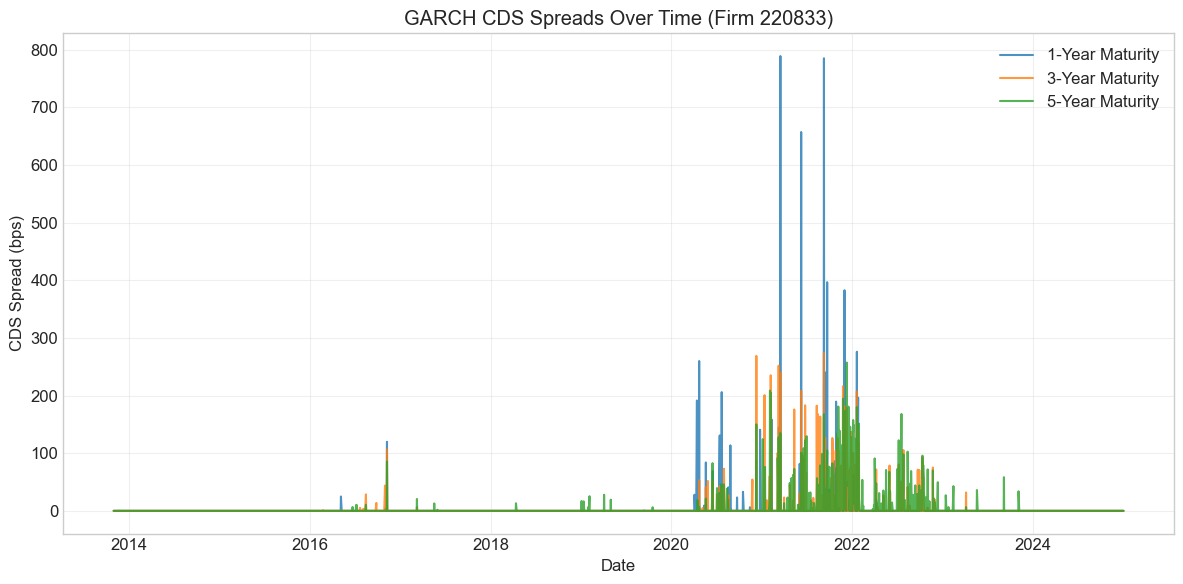

In [7]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('GARCH', gvkey=220833, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

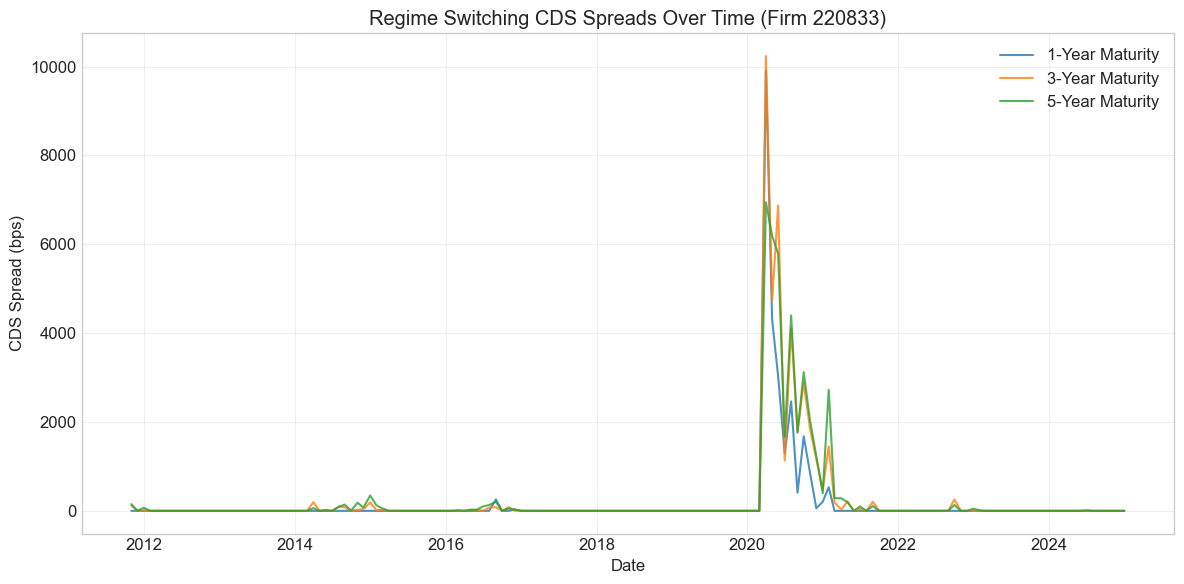

In [8]:
plotter.plot_spreads_over_time('Regime Switching', gvkey=220833, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

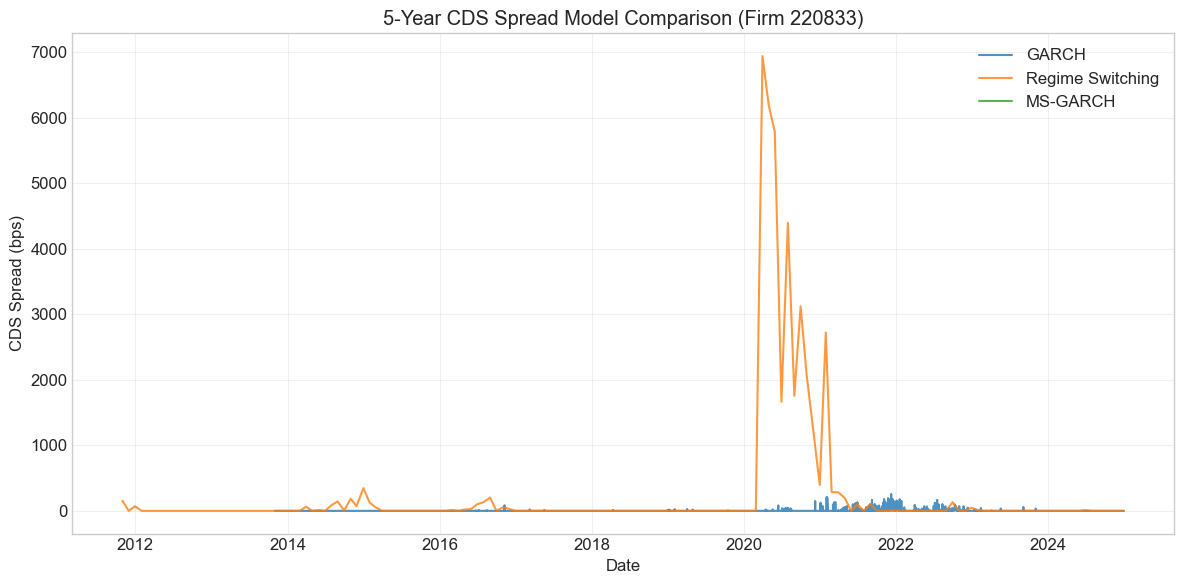

In [9]:
plotter.plot_model_comparison(gvkey=220833, maturity=5, models=['GARCH', 'Regime Switching', 'MS-GARCH'])

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

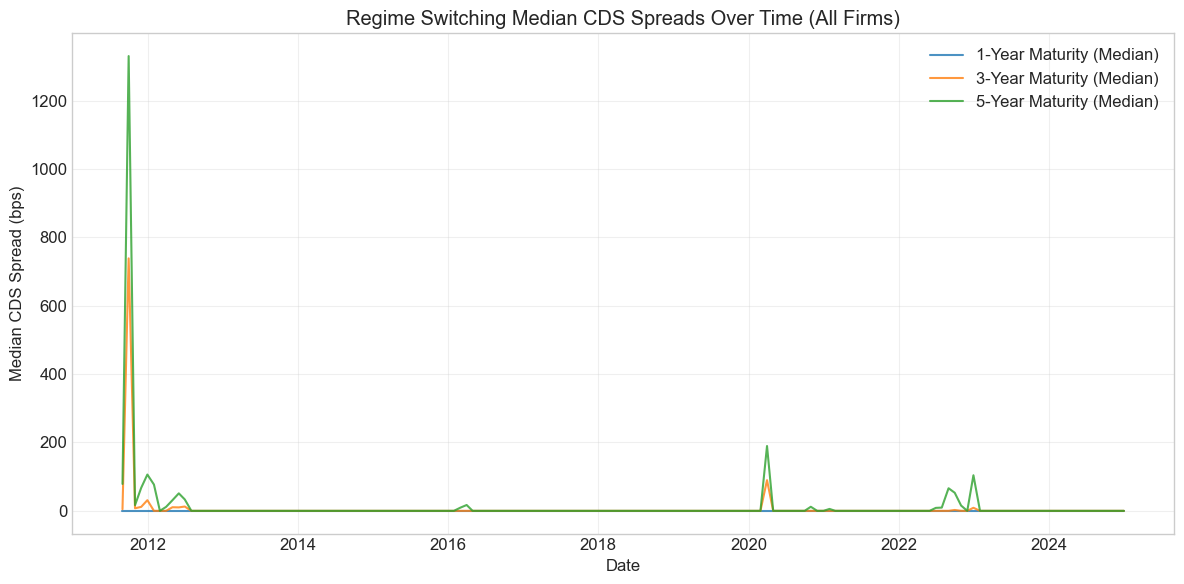

In [16]:
plotter.plot_average_spreads_over_time('Regime Switching', maturities=[1, 3, 5])

## 5. Model vs Market CDS Comparison

Compare model-implied CDS spreads with actual market CDS spreads for individual firms.

In [11]:
# Load market CDS data
import matplotlib.pyplot as plt

def load_cds_market_data(filepath, maturity):
    """Load CDS market data from Excel file."""
    df = pd.read_excel(filepath, header=None)
    
    # Row 3 has company names, data starts at row 5
    company_names_raw = df.iloc[3, 2:].tolist()
    company_names = []
    for name in company_names_raw:
        if pd.notna(name):
            clean = name.split(' SNR ')[0] if ' SNR ' in str(name) else str(name)
            company_names.append(clean)
        else:
            company_names.append(None)
    
    # Get dates and data
    dates = pd.to_datetime(df.iloc[5:, 0], errors='coerce')
    data = df.iloc[5:, 2:].copy()
    data.columns = company_names[:len(data.columns)]
    data['date'] = dates.values
    
    # Melt to long format
    data_long = data.melt(
        id_vars=['date'], 
        var_name='company_cds', 
        value_name=f'cds_market_{maturity}y_bps'
    )
    data_long[f'cds_market_{maturity}y_bps'] = pd.to_numeric(
        data_long[f'cds_market_{maturity}y_bps'], errors='coerce'
    )
    
    return data_long.dropna(subset=['date', 'company_cds'])

# Company name mapping (CDS data name -> Model data name)
# This maps the company names as they appear in CDS Excel files to how they appear in model data
COMPANY_MAPPING = {
    'ADIDAS AG': 'ADIDAS AG',
    'AIR LIQUIDE SA': "L'AIR LIQUIDE SA",
    'AIRBUS SE': 'AIRBUS SE',
    'ALLIANZ SE': 'ALLIANZ SE',
    'ANHEUSER-BUSCH INBE': 'ANHEUSER-BUSCH INBEV',
    'AXA': 'AXA SA',
    'BASF SE': 'BASF SE',
    'BAYER AG': 'BAYER AG',
    'BAYER MOTOREN WERKE': 'BAYERISCHE MOTOREN WERKE AKT',
    'BNP PARIBAS SNRFOR MM14 E - CDS PREM. MID': 'BNP PARIBAS',  # CDS data has this long name
    'DANONE SA': 'DANONE SA',
    'DEUTSCHE POST AG': 'DEUTSCHE POST AG',
    'DEUTSCHE TELEKOM AG': 'DEUTSCHE TELEKOM',
    'ENEL S.P.A.': 'ENEL SPA',
    'ENI S.P.A.': 'ENI SPA',
    'IBERDROLA, S.A.': 'IBERDROLA SA',
    'INFINEON TECS': 'INFINEON TECHNOLOGIES AG',
    'ING GROEP N.V.': 'ING GROEP NV',
    'INTESA SANPAOLO SPA': 'INTESA SANPAOLO SPA',
    'KERING SA': 'KERING SA',
    'KON AHOLD DELHAIZE': 'KONINKLIJKE AHOLD DELHAIZE',
    "L'OREAL": 'LOREAL SA',
    'LVMH MOET HENNESSY': 'LVMH MOET HENNESSY LOUIS V',
    'MUNICH REINSURANCE': 'MUNICH RE CO',
    'NOKIA OYJ': 'NOKIA OYJ',
    'ORANGE S.A.': 'ORANGE SA',
    'SANOFI SA': 'SANOFI',
    'SAP SE': 'SAP SE',
    'SCHNEIDER ELECTRIC': 'SCHNEIDER ELECTRIC S E',
    'SIEMENS AG': 'SIEMENS AG',
    'TOTALENERGIES SE': 'TOTALENERGIES SE',
    'UNICREDIT SPA': 'UNICREDIT SPA',
    'VINCI': 'VINCI SA',
    'WOLTERS KLUWER NV': 'WOLTERS KLUWER NV',
}

# Load market CDS for all maturities
input_dir = config.DATA_DIR / 'input'
cds_1y = load_cds_market_data(input_dir / 'CDS_1y_mat_data.xlsx', 1)
cds_3y = load_cds_market_data(input_dir / 'CDS_3y_mat_data.xlsx', 3)
cds_5y = load_cds_market_data(input_dir / 'CDS_5y_mat_data.xlsx', 5)

# Merge all maturities
market_cds = cds_1y.merge(cds_3y, on=['date', 'company_cds'], how='outer')
market_cds = market_cds.merge(cds_5y, on=['date', 'company_cds'], how='outer')

# Add company name mapping (map CDS names to model names)
market_cds['company'] = market_cds['company_cds'].map(COMPANY_MAPPING)

# Get company to gvkey mapping
merton_df = pd.read_csv(config.OUTPUT_DIR / 'merged_data_with_merton.csv')
company_to_gvkey = merton_df[['company', 'gvkey']].drop_duplicates().set_index('company')['gvkey'].to_dict()

# Add gvkey to market data
market_cds['gvkey'] = market_cds['company'].map(company_to_gvkey)
market_cds = market_cds.dropna(subset=['gvkey'])
market_cds['gvkey'] = market_cds['gvkey'].astype(int)
market_cds['date'] = pd.to_datetime(market_cds['date'])

print(f"✓ Loaded market CDS data: {len(market_cds)} observations")
print(f"  Unique firms: {market_cds['gvkey'].nunique()}")
print(f"  Available firms: {sorted(market_cds['gvkey'].unique())}")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Chase\\Downloads\\Seminar QF\\Seminar QF\\data\\input\\CDS_1y_mat_data.xlsx'

In [81]:
def plot_model_vs_market_scatter(gvkey, model_name, maturity=5):
    """
    Create scatter plot comparing model-implied CDS spreads vs actual market spreads.
    
    Parameters:
    -----------
    gvkey : int
        The firm identifier
    model_name : str
        The model to compare ('GARCH', 'Regime Switching', 'MS-GARCH')
    maturity : int
        Maturity in years (1, 3, or 5)
    """
    # Get model data
    if model_name not in plotter.data:
        print(f"Error: Model '{model_name}' not loaded.")
        return
    
    model_df = plotter.data[model_name]
    model_firm = model_df[model_df['gvkey'] == gvkey].copy()
    
    if model_firm.empty:
        print(f"No model data found for firm {gvkey}")
        return
    
    # Get market data
    market_firm = market_cds[market_cds['gvkey'] == gvkey].copy()
    
    if market_firm.empty:
        print(f"No market CDS data found for firm {gvkey}")
        return
    
    # Merge model and market data
    model_col = f'spread_{maturity}y_bps'
    market_col = f'cds_market_{maturity}y_bps'
    
    if model_col not in model_firm.columns:
        print(f"Error: {model_col} not found in model data")
        return
    
    if market_col not in market_firm.columns:
        print(f"Error: {market_col} not found in market data")
        return
    
    merged = model_firm[['date', 'gvkey', model_col]].merge(
        market_firm[['date', 'gvkey', market_col]],
        on=['date', 'gvkey'],
        how='inner'
    )
    
    merged = merged.dropna(subset=[model_col, market_col])
    
    if len(merged) == 0:
        print(f"No overlapping data points found")
        return
    
    # Get company name
    company_name = merton_df[merton_df['gvkey'] == gvkey]['company'].iloc[0] if len(merton_df[merton_df['gvkey'] == gvkey]) > 0 else f"Firm {gvkey}"
    
    # Calculate correlation and RMSE
    corr = merged[model_col].corr(merged[market_col])
    rmse = np.sqrt(((merged[model_col] - merged[market_col])**2).mean())
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(merged[market_col], merged[model_col], alpha=0.6, s=30)
    
    # Add 45-degree line (perfect prediction)
    min_val = min(merged[market_col].min(), merged[model_col].min())
    max_val = max(merged[market_col].max(), merged[model_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (45°)')
    
    # Add regression line
    z = np.polyfit(merged[market_col], merged[model_col], 1)
    p = np.poly1d(z)
    x_line = np.linspace(min_val, max_val, 100)
    plt.plot(x_line, p(x_line), 'b-', linewidth=2, alpha=0.7, label=f'Regression (slope={z[0]:.2f})')
    
    plt.xlabel(f'Market CDS Spread (bps) - {maturity}Y', fontsize=12)
    plt.ylabel(f'{model_name} Implied Spread (bps) - {maturity}Y', fontsize=12)
    plt.title(f'{model_name} vs Market CDS Spreads: {company_name}\n' + 
              f'Correlation: {corr:.3f} | RMSE: {rmse:.1f} bps | N={len(merged)}',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nStatistics:")
    print(f"  Observations: {len(merged)}")
    print(f"  Correlation: {corr:.4f}")
    print(f"  RMSE: {rmse:.2f} bps")
    print(f"  Mean Market Spread: {merged[market_col].mean():.2f} bps")
    print(f"  Mean Model Spread: {merged[model_col].mean():.2f} bps")
    print(f"  Mean Difference: {(merged[model_col] - merged[market_col]).mean():.2f} bps")

print("✓ Function 'plot_model_vs_market_scatter' defined")

✓ Function 'plot_model_vs_market_scatter' defined


In [82]:
def plot_all_models_vs_market(gvkey, maturity=5):
    """
    Plot time series comparing all model-implied CDS spreads with actual market spreads.
    
    Parameters:
    -----------
    gvkey : int
        The firm identifier
    maturity : int
        Maturity in years (1, 3, or 5)
    """
    # Get company name
    company_name = merton_df[merton_df['gvkey'] == gvkey]['company'].iloc[0] if len(merton_df[merton_df['gvkey'] == gvkey]) > 0 else f"Firm {gvkey}"
    
    # Get market data
    market_firm = market_cds[market_cds['gvkey'] == gvkey].copy()
    
    if market_firm.empty:
        print(f"No market CDS data found for firm {gvkey}")
        return
    
    market_col = f'cds_market_{maturity}y_bps'
    if market_col not in market_firm.columns:
        print(f"Error: {market_col} not found in market data")
        return
    
    # Create plot
    plt.figure(figsize=(14, 8))
    
    # Plot market CDS (thicker line, distinctive color)
    market_firm_sorted = market_firm.sort_values('date')
    plt.plot(market_firm_sorted['date'], market_firm_sorted[market_col], 
             linewidth=3, label='Market CDS', color='black', alpha=0.8)
    
    # Plot each model
    model_colors = {
        'GARCH': '#1f77b4',           # Blue
        'Regime Switching': '#2ca02c', # Green
        'MS-GARCH': '#d62728',         # Red
    }
    
    model_col = f'spread_{maturity}y_bps'
    
    for model_name in ['GARCH', 'Regime Switching', 'MS-GARCH']:
        if model_name in plotter.data:
            model_df = plotter.data[model_name]
            model_firm = model_df[model_df['gvkey'] == gvkey].copy()
            
            if not model_firm.empty and model_col in model_firm.columns:
                model_firm_sorted = model_firm.sort_values('date')
                color = model_colors.get(model_name, None)
                plt.plot(model_firm_sorted['date'], model_firm_sorted[model_col],
                        linewidth=1.5, label=f'{model_name}', 
                        color=color, alpha=0.7, linestyle='--')
    
    plt.title(f'CDS Spreads Comparison: {company_name} ({maturity}-Year Maturity)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('CDS Spread (basis points)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for {company_name} ({maturity}Y):")
    print(f"{'Model':<20} {'Mean (bps)':<12} {'Std (bps)':<12} {'Min (bps)':<12} {'Max (bps)':<12} {'Corr w/ Market':<15}")
    print("-" * 90)
    
    # Market stats
    market_data = market_firm_sorted[market_col].dropna()
    print(f"{'Market CDS':<20} {market_data.mean():>10.2f}  {market_data.std():>10.2f}  {market_data.min():>10.2f}  {market_data.max():>10.2f}  {'N/A':<15}")
    
    # Model stats
    for model_name in ['GARCH', 'Regime Switching', 'MS-GARCH']:
        if model_name in plotter.data:
            model_df = plotter.data[model_name]
            model_firm = model_df[model_df['gvkey'] == gvkey].copy()
            
            if not model_firm.empty and model_col in model_firm.columns:
                # Merge with market for correlation
                merged = model_firm[['date', model_col]].merge(
                    market_firm[['date', market_col]],
                    on='date',
                    how='inner'
                )
                merged = merged.dropna()
                
                model_data = model_firm[model_col].dropna()
                
                if len(merged) > 1:
                    corr = merged[model_col].corr(merged[market_col])
                    print(f"{model_name:<20} {model_data.mean():>10.2f}  {model_data.std():>10.2f}  {model_data.min():>10.2f}  {model_data.max():>10.2f}  {corr:>13.4f}")
                else:
                    print(f"{model_name:<20} {model_data.mean():>10.2f}  {model_data.std():>10.2f}  {model_data.min():>10.2f}  {model_data.max():>10.2f}  {'N/A':<15}")

print("✓ Function 'plot_all_models_vs_market' defined")

✓ Function 'plot_all_models_vs_market' defined


### 5.1 Scatter Plot: Model vs Market CDS Spreads

Compare a single model's implied spreads against actual market CDS spreads.
- Shows correlation between model and market
- 45-degree line indicates perfect prediction
- RMSE measures average prediction error

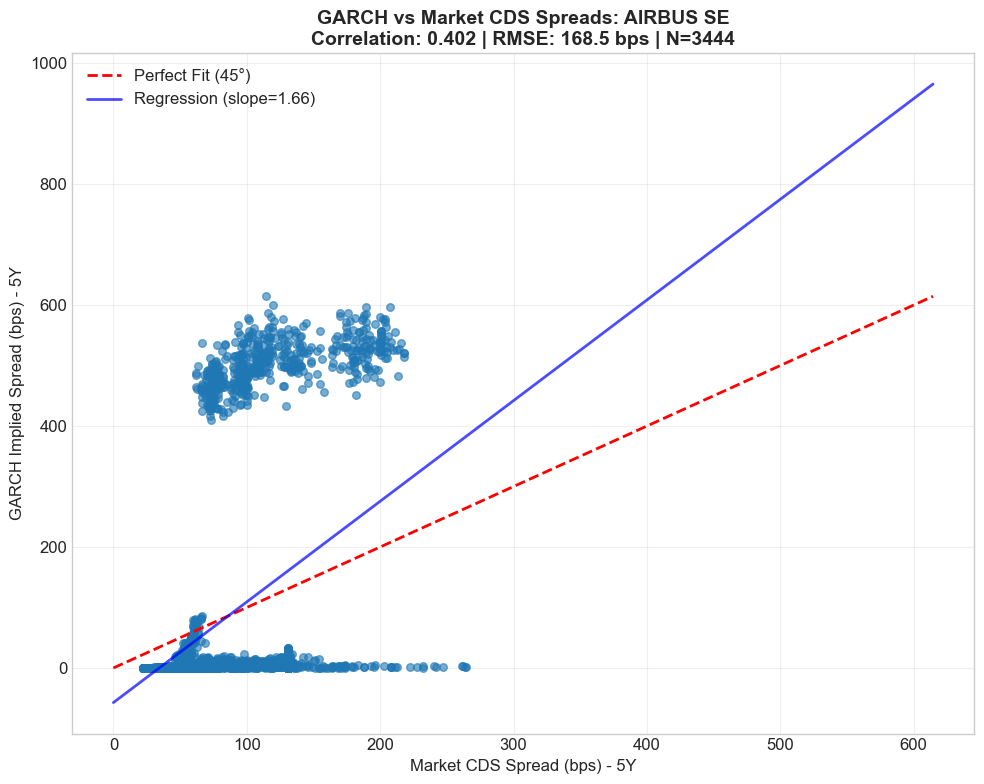


Statistics:
  Observations: 3444
  Correlation: 0.4020
  RMSE: 168.55 bps
  Mean Market Spread: 82.63 bps
  Mean Model Spread: 80.30 bps
  Mean Difference: -2.33 bps


In [102]:
# Example: Compare GARCH model vs market for a specific firm
# Available firms can be found in the market_cds dataframe
plot_model_vs_market_scatter(gvkey=220833, model_name='GARCH', maturity=5)

In [84]:
# Compare Regime Switching model vs market (3-year maturity)
plot_model_vs_market_scatter(gvkey=220833, model_name='Regime Switching', maturity=3)

No market CDS data found for firm 220833


### 5.2 Time Series: All Models vs Market CDS Spreads

Compare all four model-implied spreads with actual market CDS spreads over time.
- Market CDS shown as thick black line
- Model-implied spreads shown as dashed lines
- Summary statistics table shows correlation of each model with market

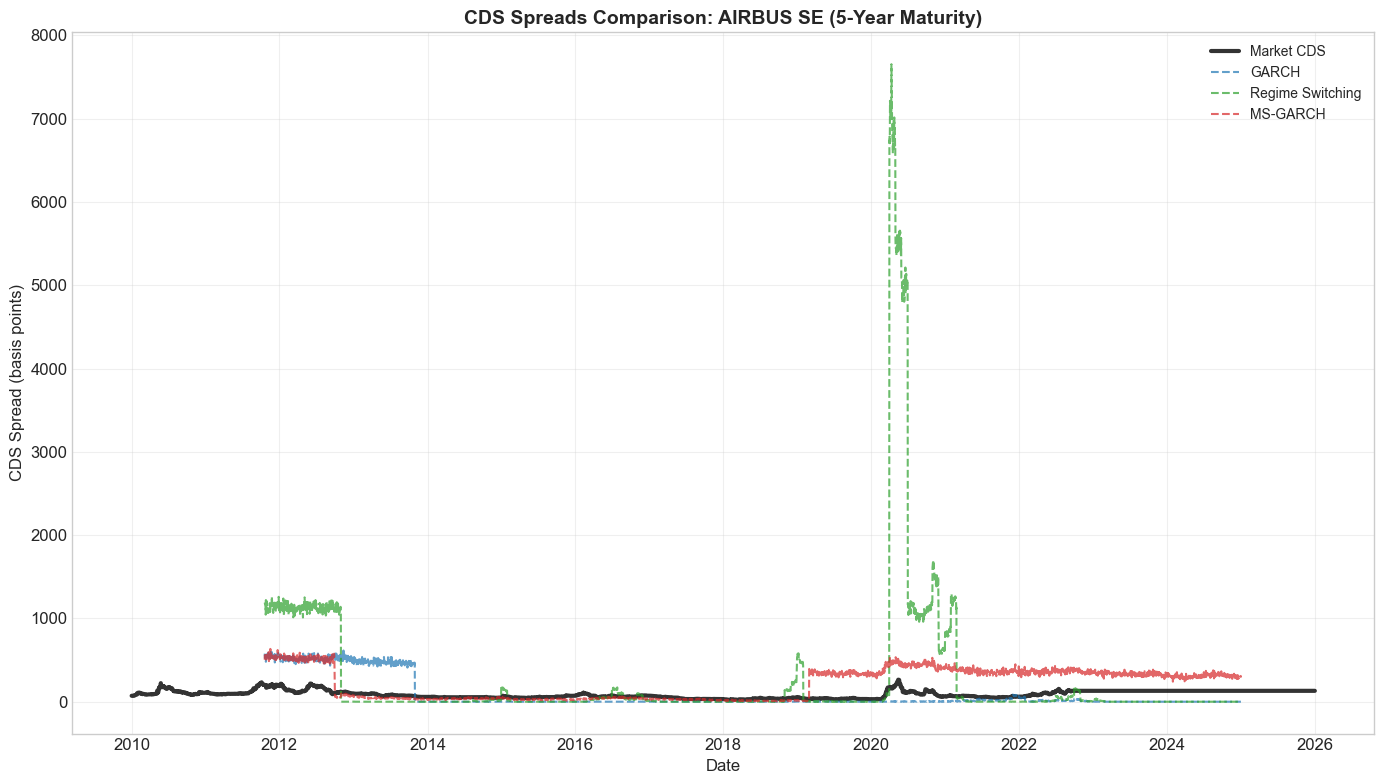


Summary Statistics for AIRBUS SE (5Y):
Model                Mean (bps)   Std (bps)    Min (bps)    Max (bps)    Corr w/ Market 
------------------------------------------------------------------------------------------
Market CDS                89.24       44.07       22.04      264.72  N/A            
GARCH                     80.30      181.32        0.00      614.54         0.4020
Regime Switching         264.79      861.12        0.00     7654.99         0.4540
MS-GARCH                 211.88      182.43        3.89      634.00         0.6306


In [101]:
# Example: Compare all models vs market for a specific firm (5-year maturity)
plot_all_models_vs_market(gvkey=220833, maturity=5)

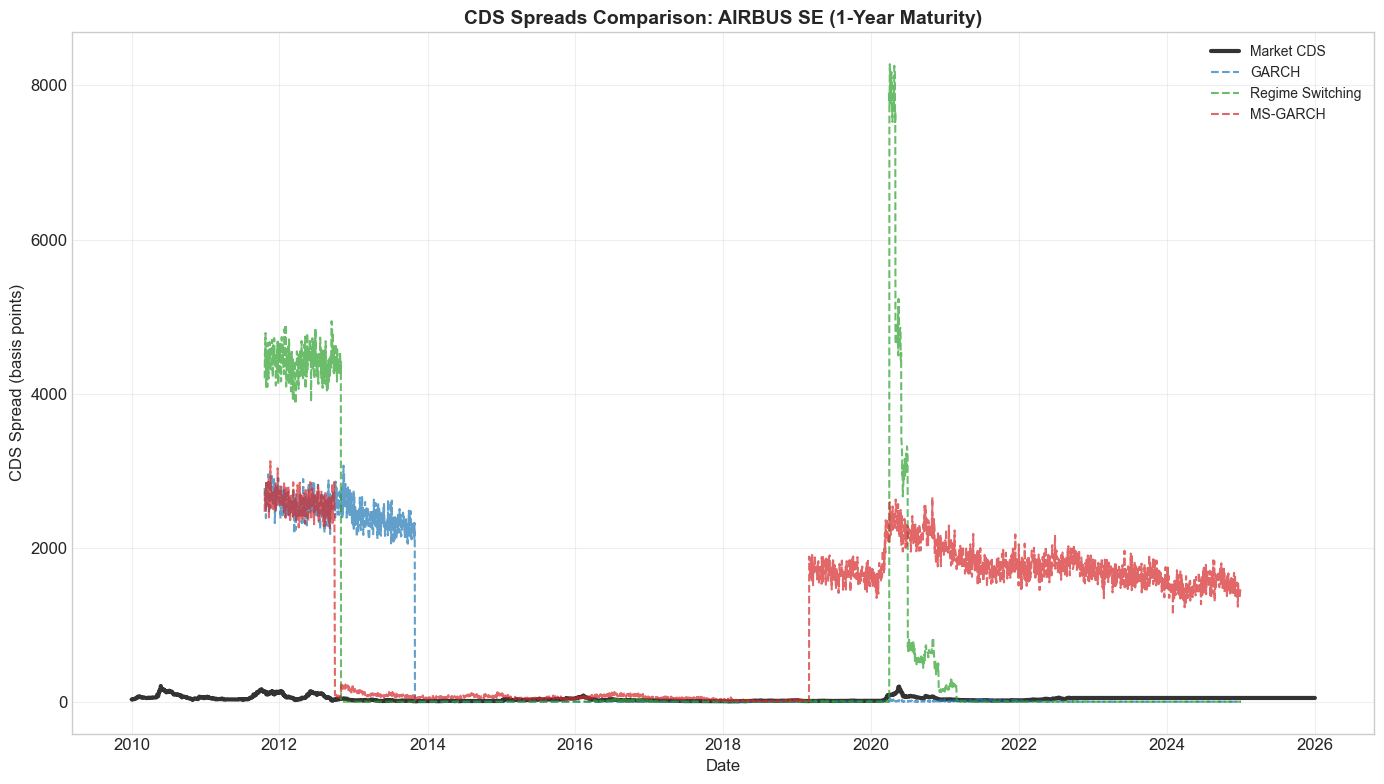


Summary Statistics for AIRBUS SE (1Y):
Model                Mean (bps)   Std (bps)    Min (bps)    Max (bps)    Corr w/ Market 
------------------------------------------------------------------------------------------
Market CDS                35.95       29.12        3.66      204.14  N/A            
GARCH                    383.30      897.80        0.00     3065.40         0.2998
Regime Switching         466.71     1380.84        0.00     8276.01         0.6579
MS-GARCH                 987.90      943.25        1.59     3121.70         0.6162


In [103]:
# Try with 1-year maturity
plot_all_models_vs_market(gvkey=220833, maturity=1)